# Gaussian Processes

In this chapter we will consider *Gaussian Processes* for uncertainty quantification. Our setup is the following:
<br>
We have labeled data $\mathcal{D} = \{(y_{1}, {\bf x}_{1}),...,(y_{n}, {\bf x}_{n}) \} \subset \mathcal{Y} \times \mathcal{X}$, where we assume that each observaton is some function of the input, e.g. $y_{i} = f({\bf x}_{i})$. Especially we assume we have a (prior-) distribution of possible functions that could give rise to the observed data.Therefore our Hypothesis Space $\mathcal{H}$ is a set of possible function that could have generated the data. The more data we observe, the narrower is the choice of possible functions that can explain the oberservations. More precisely we assume that the distribution mus be in the family of multivariate Gaussians which leads to the notion of a Gaussian Process defined below:

````{prf:definition}
:label: def-gauss-process

Let $\mathcal{I}$ be some index set and let $S \subset \mathcal{P}(\mathcal{I})$ be finite. Further let ${\bf Y}_{i}$ be iid Gaussian, e.g. ${\bf Y}_{i} \sim \mathcal{N}(\mu, \sigma^{2})$ $\forall i \in \mathcal{I}$
The sequence $({\bf Y}_{i})_{i \in \mathcal{I}}$ is a Gaussian Process if for each $S$ the finite sequence $({\bf Y}_{j})_{j \in S}$ is multivariate Gaussian e.g. ${\bf Y}_{s} \sim \mathcal{N}(\mu, \sigma^{2})$ $\forall s \in S$
````

Multivariate gaussian distributions are specified via a mean vector and a covariance matrix. For Gaussian Processes the the covariance matrix has a special form: each entry can be expressed as a dot product of the input features $\bf x$ in some (typically high dimensional)  feature space $\phi({\bf x})$. The dot product itself is often not specified but rather a kernel function for two inputs $k({\bf x}, {\bf x}^{\prime})$. The covariance function is then defined componentwise as:
$${\bf K}_{i,j}= k({\bf x}_{i}, {\bf x}_{j})$$
An example would be the radial basis function $k({\bf x}_{i}, {\bf x}_{j}) = \text{exp}(\frac{1}{2l}||{\bf x}_{i} - {\bf x}_{j}||^2)$ where one can show that this can be express as some dotproduct $\phi({\bf x}_{i})^{T} \phi({\bf x}_{j})$ for appropriate definition of $\phi$.
To finalize notation we have:

$${\bf y} \sim \mathcal{N}({\bf \mu}, {\bf K}), {\bf y} = [f({\bf x})_{1},...,f({\bf x}_{n})]^{T},
{\bf \mu} = [m({\bf x}_{1}),...m({\bf x}_{n})]^{T}$$

The covariance function above has only one hyperparameter, the length scale $l$ which controls how close two datapoints in the inputspace $\bf x$ are in outputspac $\bf y$ (if two points close in input space are close in output space the function will behave less 'wiggly'). Typically this is not the only hyperparameter but reasonable covariance functions depend on multiple hyperparameters allowing greater fexibility in modelling the depence structure. Also we can allow for noisy observations, e.g. $y_{i} = f({\bf x}_{i}) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma_{\epsilon}^{2})$ by adding gaussian noise $\sigma^{2}_{n}$ to the covariance function. Using dirac-delta notation the covariance kernel is now:
$${\bf K}_{i,j}= k({\bf x}_{i}, {\bf x}_{j}) + \delta_{ij}\sigma^{2}_{\epsilon}$$
Other possible covariance functions are for example the Matérn and Polynomial kernel as well as the periodic :
$$k_{Mat}({\bf d})= \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \sqrt{2 \nu}d \right)^{\nu} K_{\nu}(\sqrt{2 \nu}d)$$

$$k_{Poly}({\bf x}_{1}, {\bf x}_{2}) = ({\bf x}_{1}^{T}{\bf x}_{2} + c)^{d}$$
where $K_{\nu}$ is a modified Bessel-function and $\Gamma()$ is the gamma function.<br>

Since the each ${\bf x}_{i}$ if realization of a random variable we have two variances or standard deviations to consider: The standard devation due to a noisy observation $\epsilon$, e.g. $\sigma_{\epsilon}$ and the standard deviation of each individual posterior predictive Gaussian $\sigma_{i}$ where $\sigma_{i}$ captures the total unceratainty and $\sigma_{\epsilon}$ the aleatoric uncertainty which could be reduced by more observations.<br>
In the following we give an illustration by creating some artifical data. Let us first import the necessary libraries and define some functions for better illustration:

In [31]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from copy import deepcopy
from itertools import product as iterprod


from scipy.stats  import norm as normal
from sklearn import gaussian_process as gp
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor

import torch
import gpytorch

In [32]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float64)
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams["figure.figsize"] = (8, 6)
pd.options.display.float_format = '{:.3f}'.format

We assume the actual data is defined by $\sin(x) \times \frac{x}{2}$ to which we add some noise drawn from a Gaussian distribution implemented in `true_func` and `add_error`. We also define how many samples to draw and the resolution on for the real numbers we use as input.

In [73]:
noise = 2
x_min = 0,
x_max = 20
granularity = 500
n_samples = int(np.ceil(granularity / 20))

In [33]:
def true_func(x):
    """
    Return the actual function value(s).

    This function takes some input number(s) and create the actual function value, e.g. this function implements $y_{i] = f(x_{i})$.
    """
    return np.sin(x) * 0.5 * x
    
def add_error(x, noise):
    """
    Add Gaussian error terms to input.

    This function adds some error term drawn from a normal centered at zero with given variance to the input, e.g.:
    $y_{i} = f(x_{i}) + \epsilon{i}$
    """
    return x + np.random.normal(0, noise, len(x))
    

In [74]:
x_line = np.linspace(x_min, x_max, num = granularity).squeeze()
x_train = np.random.choice(a = x_line, size = n_samples, replace = False)
y_train = add_error(true_func(x_train), noise)

y_data = pd.concat([
    pd.DataFrame({"y":true_func(x_line)}, index = x_line),
    pd.DataFrame({"y_train": y_train}, index = x_train)])

The following block contains functions for plotting which might not be of primary interes.

In [80]:
def concat_obs(df, y_obs = y_train, x_obs = x_train):
    """
    Typically if we have predictions we want to add the actual observations as well, this is a handy shortcut.
    """
    df_new = df.join(pd.DataFrame({"obs": y_obs}, index = x_obs))
    return df_new


def plot_gp_frame(df, title):
    """
    Create a plot from a dataframe with predictions and observations.
    """
    
    plt.plot(df.drop("obs", axis = 1), label = df.drop("obs", axis = 1).columns)
    plt.plot(df["obs"], "kx", label = "observation")
    plt.xaxis("$x$")
    plt.yaxis("$f(x)$")
    plt.title(title)


def get_normal_vals(df, percentile = 50, pred_val = None, y_min = true_func(x_line).min(), y_max = true_func(x_line).max()):
    """
    Since the predictions of a GP specify a marginal Gaussian distribution for each x this function takes some x values
    from the nearest given percentile say $x_{j}$ and calculates the corresponding Gaussian $\mathcal{N}(\mu_{j}, \sigma_{j}^2{2}$.
    The parameters are stored in the given dataframe.
    """
    assert(isinstance(df, pd.DataFrame))
    assert(all([word in df.columns for word in ["pred", "sd"]]))
    assert (percentile < 100 and percentile > 0), f"expected percentile to be in range(0,100), got: {percentile}"

    if not pred_val:
        # note: x values are the indices of the dataframe
        x_val = np.percentile(x_line, percentile, method = "nearest")
        query = df[df.index == x_val]
    else:
        assert(pred_val in df.pred)
        query = df[df.pred == pred_val]
    
    assert(not np.all((np.isnan(query[["pred", "sd"]])).values))
        
    normal_mean = query.pred.values
    normal_sd = query.sd.values
    n = normal(loc = normal_mean, scale = normal_sd)

    y_values  = np.linspace(y_min, y_max,  1000)
    x_values = n.pdf(y_values)
    
    return x_values + x_val , y_values

def plot_normals(df, percentiles, kwargs):
    """
    Plot density of the marginal Gaussian for some values to the nearest given percentiles.
    """
    for percentile in percentiles:
        x_val = np.percentile(df.index, percentile, method = "nearest")
        mean_val = df.loc[x_val].pred

        x_vals, y_vals = get_normal_vals(df = df, percentile = percentile)
        plt.plot(x_vals, y_vals, **kwargs)
        plt.plot(x_val, mean_val, **kwargs)
        plt.scatter(x_val, mean_val, **kwargs)
        plt.hlines(y = mean_val, xmin = x_val, xmax = max(x_vals) + 0.0001, **kwargs)
        

def get_model_vals(model, x_line):
    """
    Create a DataFrame with marginal means and standarddeviations.
    """
    pred_mean, pred_sd = model.predict(x_line.reshape(-1,1), return_std = True)
    data = pd.DataFrame({"pred": pred_mean, "sd": pred_sd},index = x_line)
    model = None
    return data


def get_rbf_preds(lengthscale, noise, x_train = x_train.reshape(-1,1), y_train = y_train, as_frame = False, optimize = False):
    """
    Fit a GP model with a RBF Kernel and return results in DataFrame.
    """
    kernel = gp.kernels.RBF(length_scale = lengthscale)
    model = GaussianProcessRegressor(kernel, alpha = noise ** 2,n_restarts_optimizer = 9)
    model.fit(x_train.reshape(-1,1), y_train)
    data = get_model_vals(model, x_line)
    
    if as_frame:
        return data
        
    return data.pred.values, data.sd.values
    
def get_matern_preds(lengthscale, nu, noise, x_train = x_train.reshape(-1,1), y_train = y_train, as_frame = False, optimize = False):
    """
    Fit a GP model with a Matern Kernel and return results in DataFrame.
    """
    kernel = gp.kernels.Matern(length_scale = lengthscale, nu = nu)
    model = GaussianProcessRegressor(kernel, alpha = noise ** 2, n_restarts_optimizer = 9)
    model.fit(x_train.reshape(-1,1), y_train)
    data = get_model_vals(model, x_line)
    
    if as_frame:
        return data
        
    return data.pred.values, data.sd.values

The plot below illustrates the data we just generated:

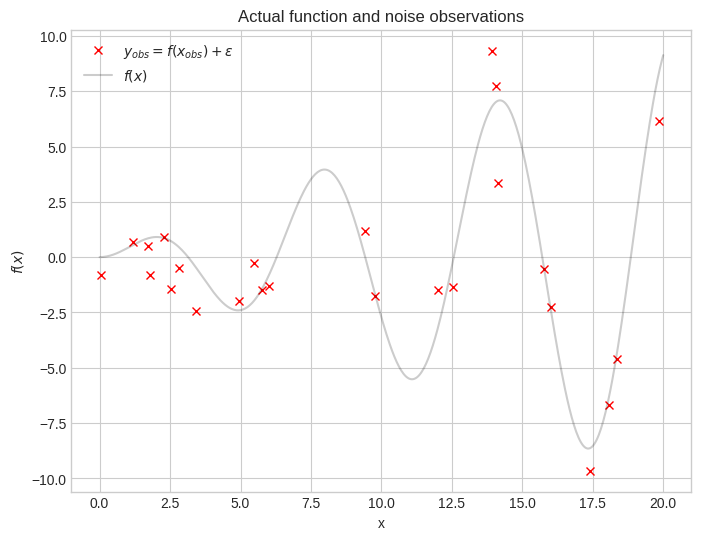

In [84]:
plt.plot(y_data["y_train"], "rx", label = "$y_{obs} = f(x_{obs}) + \epsilon$")
plt.plot(y_data["y"],  "k-", label = r"$f(x)$", alpha = 0.2)
plt.legend(loc = "lower left")
plt.ylabel(r"$f(x)$")
plt.xlabel("x")
plt.title("Actual function and noise observations")
plt.legend(loc = "upper left")
plt.show()

Given our observations we can fit a Gaussian Process using maximum Likelihood methods. For that we have to specify the kernel (including) hyperparameters) and the Gaussian noise which contanimnates our observations. <br>
The plot below shows the actual function, the noise observations and the mean preadictions. Since for prediction we do not have a scalar value but a distribution a natural choice is to use its mean value for prediction, shown as the blue line . Also indicated is the predictive distribution for some more or less arbitrary chosen query points.

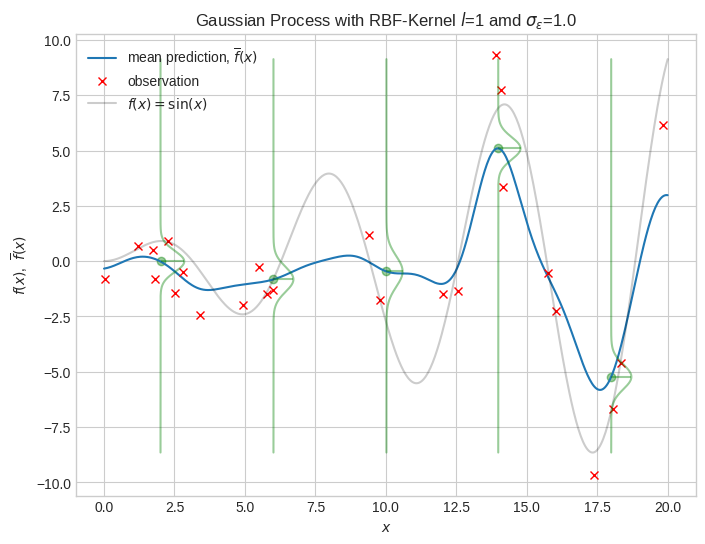

In [86]:
length_scale = 1
noise_sd = 1.0

kernel = gp.kernels.RBF(length_scale = length_scale)
model = GaussianProcessRegressor(kernel, alpha = noise_sd ** 2,n_restarts_optimizer = 1)
model.fit(x_train.reshape(-1,1), y_train)

data = get_model_vals(model, x_line)
data = concat_obs(data)
percentiles = np.array([10, 30, 50,  70, 90])

plt.plot(data["pred"], label = r"mean prediction, $\overline{f}(x)$")
plt.plot(data["obs"], "rx", label = "observation")
plt.plot(y_data["y"], "k-", label = r"$f(x) =\sin (x)$", alpha = 0.2)
plot_normals(data, percentiles, {"alpha": 0.4, "color":"g", "linestyle": "-"})
plt.title(r"Gaussian Process with RBF-Kernel $l$=l_scale amd $\sigma_{\epsilon}$=n_sd".replace("l_scale", str(length_scale)).replace("n_sd", str(noise_sd)))
plt.xlabel("$x$")
plt.ylabel("$f(x)$,  $\overline{f}(x)$")
plt.legend(loc = "upper left")
plt.show()

Depending on how noisy we assume our observations to be, the more each observation can deviate from the mean prediction of it and the less accurate the resulting Gaussian Process interpolates between the observation. The plots below illustrate this for a radial basis function kernel as well as a matern kernel (which seems to not deviate much from each other).

In [71]:
def gp_ax_plot(noise, ax, title = "", xlabel = "$x$", ylabel = "$\overline{f}(x)$", lscales = [1, 1, 1], nuscales = [0.5, 1.5]):
    """
    Plot the result of fitting a Gaussian Process on some data with help of the functions defined above.
    """
    
    ax.plot(get_rbf_preds(lengthscale = lscales[0], noise = noise, as_frame = True).pred,
         "-",
         color = "orange",
         label = r"$RBF(l=l_scale)$".replace("l_scale", str(lscales[0])),
        alpha = 0.6)
    ax.plot(get_matern_preds(lengthscale = lscales[1], nu = nuscales[0], noise = noise, as_frame = True).pred,
         "-",
         color = "blue",
         label = r"$Matern(l=l_scale,\nu=nu_scale)$".replace("l_scale", str(lscales[1])).replace("nu_scale", str(nuscales[0])),
        alpha = 0.6)
    ax.plot(data["obs"], "rx", label = "observation")
    ax.plot(y_data["y"], "k-", label = r"$f(x) =\sin (x)$", alpha = 0.2)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend(loc = "upper left")

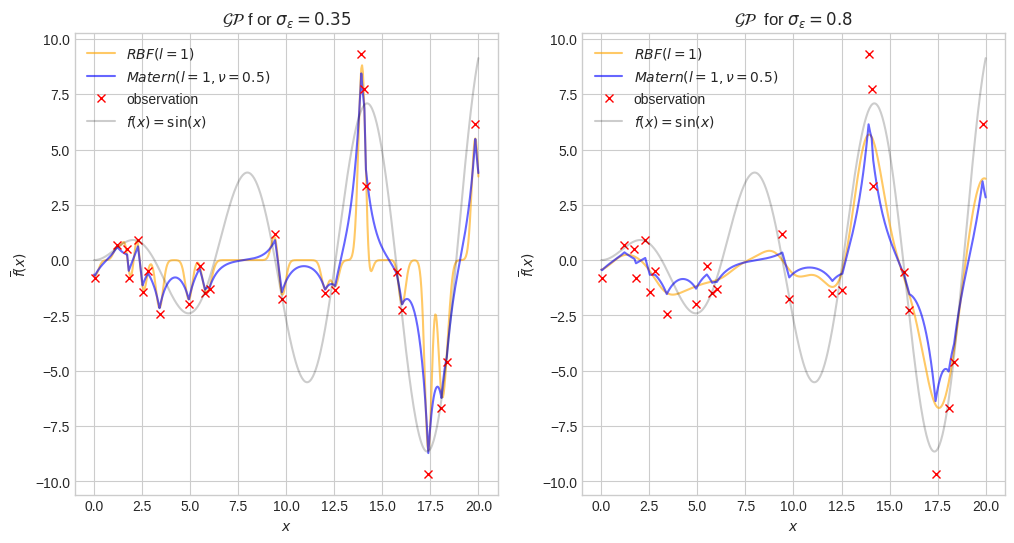

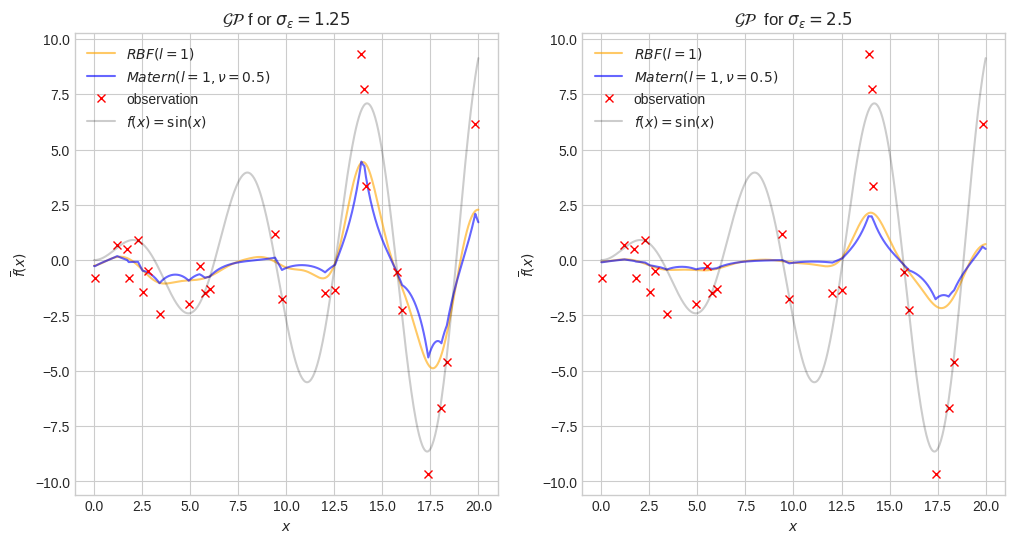

In [87]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
gp_ax_plot(noise = 0.35, ax = ax[0], title = "$\mathcal{GP}$ f or $\sigma_{\epsilon}=0.35$")
gp_ax_plot(noise = 0.8, ax = ax[1], title = "$\mathcal{GP}$  for $\sigma_{\epsilon}=0.8$")
fig, ax = plt.subplots(1, 2, figsize = (12,6))
gp_ax_plot(noise = 1.25, ax = ax[0], title = "$\mathcal{GP}$ f or $\sigma_{\epsilon}=1.25$")
gp_ax_plot(noise = 2.5, ax = ax[1], title = "$\mathcal{GP}$  for $\sigma_{\epsilon}=2.5$")

As the plot above illustrates severeal Gaussian Processes with different hyperparameters can give rise to a more or less meaningful result. To pin down only one it seems best to adhere to some optimality criterion for choosing some best fit to the given data. 
For this the hyperparameters can be optimized via Maximum Likelihood estimation. To do this for the example data above we use the `GPytorch` package which uses pytorch and has similar syntax. We first define a model class similar to pytorch modules, but importantly the forward method will return a distribution (the predictive distributon of the input $x$, our query variable). We also define functions for training and testing(=prediction) which resembles a typical pytorch procedure (altough for neural networks).

In [39]:
class ExactGPModel(gpytorch.models.ExactGP):
    """
    This class implements a Gaussian Process.
    
    The model is based on the example from the package itself:
    (see: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html).
    A kernel class object is needed for the kernel and a likelihood object to specifiy the noise distribution $\epsilon$ of the actual data,
    e.g. $y_{i} = f(x_{i}) + \epsilon$.
    """
    def __init__(self,x_train, y_train, likelihood, kernel):
        
        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train)
        
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_model(model, likelihood, x_train, y_train, epochs = 100):

    x_train = torch.from_numpy(x_train)
    y_train = torch.from_numpy(y_train)
    
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        
def eval_model(model, likelihood, x_test, as_df = True):
    
    x_test = torch.from_numpy(x_test)
    
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        pred_dist = likelihood(model(x_test))
        pred_mean = pred_dist.mean.numpy()
        pred_sd = pred_dist.stddev.numpy()

    if as_df:
        return pd.DataFrame({"pred": pred_mean, "sd": pred_sd}, index = x_test.numpy())
        
    return pred_mean, pred_sd

def get_hyperparam_df(model, model_name, df_old = None, prec = 4):
    """
    Shortcut function to extract the hyperparameters saved in parameter store of model.
    """
    # columns with value for row 'model_name'
    param_names, param_values = zip(*(model.named_parameters()))
    param_values = map(lambda x: round(x.detach().item(),prec), param_values)
    data = pd.DataFrame([param_values], columns=param_names, index=[model_name])

    if df_old is None:
        return data
    else:
        df_new = pd.concat([df_old, data])
        df_new = df_new.reindex(columns = df_old.columns, fill_value = pd.NA)
        return df_new

In [40]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel_matern = gpytorch.kernels.MaternKernel(nu=2.5)
kernel_rbf = gpytorch.kernels.RBFKernel()

model_rbf = ExactGPModel(x_train , y_train, likelihood, kernel_rbf)
model_matern = ExactGPModel(x_train , y_train, likelihood, kernel_matern)

In [41]:
train_model(model_matern, likelihood, x_train, y_train)
train_model(model_rbf, likelihood, x_train, y_train)

We trained two Gaussian Processes, one with a radial basis function kernel and one with a Matern kernel.
Below you can see the value of the optimal hyperparameters. $\sigma_{\epsilon}$ is given by `likelihodd.noise_covar.raw_noise` both models seem to agree on its estimation.

In [42]:
hypers = get_hyperparam_df(model_rbf, "rbf",get_hyperparam_df(model_matern, "matern"))
hypers

,likelihood.noise_covar.raw_noise,mean_module.raw_constant,covar_module.raw_outputscale,covar_module.base_kernel.raw_lengthscale
matern,7.689,-0.435,4.179,0.067
rbf,7.689,-0.539,5.348,0.229


Now let us plot the result including a 95% confidence region for the predictive distribution:

In [43]:
def add_upper_lower(df, critical_value = 1.96):
    """
    Add upper and lower confidence bounds to data.

    Since the distribution is Gaussian mean and standard deviation are enough to get confidence bounds.
    By default this is the 5% confidence bound with a critical value of approx. 1.96.
    """
    assert df.columns.isin(["pred", "sd"]).all()
    df_new = df.copy()
    df_new["upper"] = df_new["pred"] + critical_value * df["sd"]
    df_new["lower"] = df_new["pred"] - critical_value * df["sd"]
    return df_new

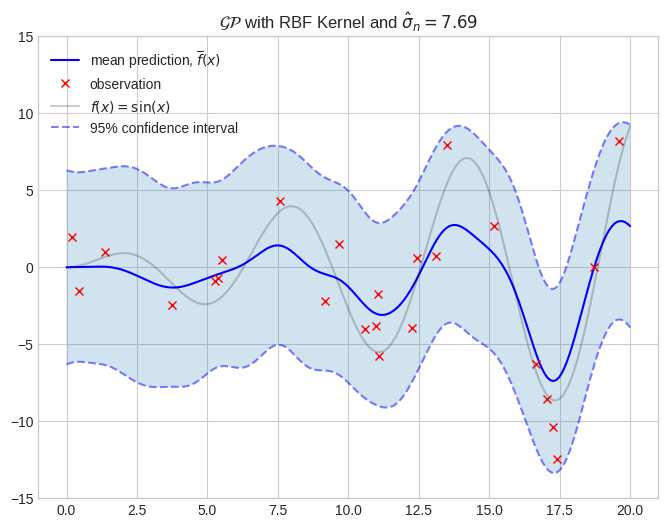

In [70]:
data_rbf = eval_model(model_rbf, likelihood, x_line)
data_rbf = add_upper_lower(data_rbf)
data_rbf = concat_obs(data_rbf)
estimated_noise = round(hypers.loc["rbf"]["likelihood.noise_covar.raw_noise"], 2)

plt.plot(data_rbf["pred"], color = "blue",label = r"mean prediction, $\overline{f}(x)$")
plt.plot(data_rbf["obs"], "rx", label = "observation")
plt.plot(y_data["y"], "k-", label = r"$f(x) =\sin (x)$", alpha = 0.2)
plt.title("$\mathcal{GP}$ with RBF Kernel and $\hat{\sigma}_{n}=estimated_noise$".replace("estimated_noise", str(estimated_noise)))
plt.plot(data_rbf["upper"], color = "blue", linestyle = "--", alpha = 0.5, label = "95% confidence interval")
plt.plot(data_rbf["lower"], color = "blue", linestyle = "--", alpha = 0.5)
plt.fill_between(data_rbf.index, data_rbf["upper"], data_rbf["lower"], alpha = 0.2)
plt.legend(loc = "upper left")
plt.ylim(-15, 15)
plt.show()

For further illustration we generate some new observations and inspect how the confidence interval changes as we sequentiall incorporate each new observation into our model.

In [45]:
new_samples = 10
x_line_new  = np.linspace(20, 30, granularity)
x_train_new = np.random.choice(x_line_new, new_samples, replace = False)
x_train_new = np.sort(x_train_new)
y_new_observed = add_error(true_func(x_train_new), noise)
x_line_updated = np.append(x_line, x_line_new)
new_data = pd.DataFrame({"y_new": y_new_observed}, index = x_train_new)
new_data

,y_new
20.902,10.623
21.343,1.389
21.523,7.948
21.864,0.504
25.050,0.080
25.671,5.077
28.377,-3.977
28.437,-2.430
28.477,-2.775
29.940,-15.007


Having sampled some new observations the plot below illustrates the new situation:

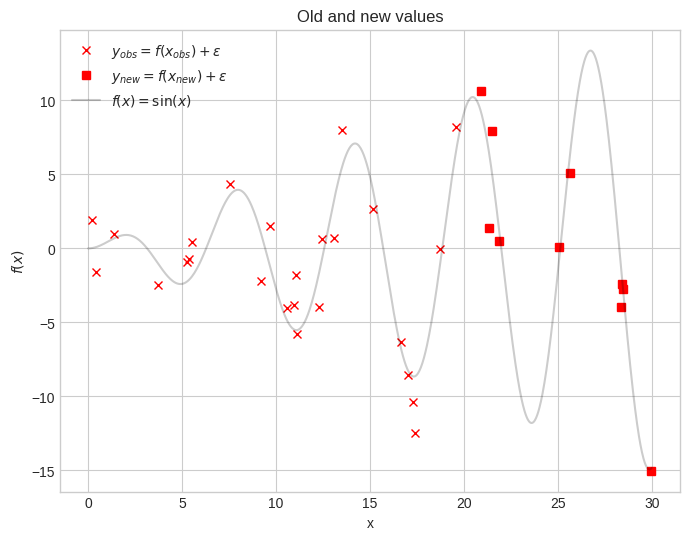

In [46]:
plt.plot(y_data["y_train"], "rx", label = "$y_{obs} = f(x_{obs}) + \epsilon$")
plt.plot(new_data["y_new"], "rs", label = "$y_{new} = f(x_{new}) + \epsilon$")
plt.plot(pd.DataFrame({"func": true_func(x_line_updated)}, index = x_line_updated), "k-", label = r"$f(x) =\sin (x)$", alpha = 0.2)
plt.ylabel(r"$f(x)$")
plt.xlabel("x")
plt.legend(loc = "upper left")
plt.title("Old and new values")
plt.show()

Now we refit our previous model each time one of the new data points is observed. The prediction for the remaining, unobserved data points would be the mean prediction indicated by the straight blue line.

In [47]:
# Set up initial data for which new data will be added and sequentially the model will be refitted.

model_update = deepcopy(model_rbf)
sequential_predictions = pd.DataFrame(index = x_train_new)
x_train_update = x_train
y_train_update = y_train
x_line_update = x_line

df_list = list()
df_params = pd.DataFrame()
sequential_data = list()     # for 10 DataFrames of sequentially added observations to old ones
sequential_models = list()  # for 10 updated models with one new training point

# Now iterate obver each new observation...
for idx, (new_obs, new_x) in enumerate(zip(y_new_observed, x_train_new)):
     # ... and update the model and save intermediate data:
    
    # re-train model on updated data (in first iteration retrain again on same data)
    model_update.set_train_data(torch.from_numpy(x_train_update), torch.from_numpy(y_train_update), strict=False)
    train_model(model_update, likelihood, x_train_update, y_train_update)
    
    # adjust x axis to incorporate new data point
    new_line_section = np.linspace(x_line_update.max(), new_x, num = granularity).squeeze()
    x_line_update = np.append(x_line_update, new_line_section)
    
    # get prediction for new data point and old ones (adjusted due to new model training)
    data_update = eval_model(model_update, likelihood, x_line_update)
    
    df_list.append(add_upper_lower(data_update))
    
    # get model parameters
    model_name = "model_" +str(idx)
    df_params = pd.concat([df_params, get_hyperparam_df(model_update, model_name)])
    
    x_train_update = np.append(x_train_update, new_x)
    y_train_update = np.append(y_train_update, new_obs)

    # update data stream
    sequential_models.append(deepcopy(model_update))
    sequential_data.append(pd.DataFrame({"y": y_train_update}, index = x_train_update))

In [69]:
def make_plot(idx, clear = False, ax = None):
    """
    Shortcut function to plot the results of each iteration from above.
    """
    if clear:
        ax.clear()
    
    observations = sequential_data[idx]
    pred_idx = sequential_data[-1].index.difference(observations.index)
    predictions = sequential_data[-1].loc[pred_idx]

    df_pred = eval_model(sequential_models[idx], likelihood, x_line_update)
    df_pred = add_upper_lower(df_pred)

    plt.plot(pd.DataFrame({"func": true_func(x_line_updated)}, index = x_line_updated), "k-", label = r"$f(x) =\sin (x)$", alpha = 0.2)
    plt.title(str(idx) + " new prediction(s):")
    plt.plot(observations, "rx", label = "observations")
    plt.plot(predictions, "rs", label = "predictions")
    plt.plot(df_pred["pred"], color = "blue",label = r"mean prediction, $\overline{f}(x)$")
    plt.plot(df_pred["upper"], color = "blue", linestyle = "--", alpha = 0.5)
    plt.plot(df_pred["lower"], color = "blue", linestyle = "--", alpha = 0.5)
    plt.fill_between(df_pred.index, df_pred["upper"], df_pred["lower"], alpha = 0.2)
    plt.plot()
    plt.xlabel("x")
    plt.ylabel("$f(x)$")
    plt.legend(loc = "upper left")

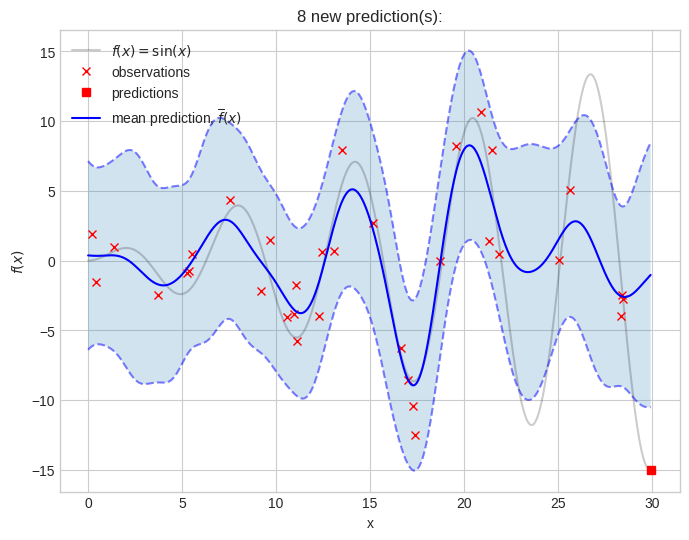

In [68]:
make_plot(8)